In [16]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import warnings
import pandas as pd
warnings.filterwarnings("ignore")

In [17]:
mer_catalog = {'53.0_-28.0': 'EUC_MER_FINAL-CAT_TILE102044185-530716_20250729T003328.783247Z_00.00.fits',
               '58.9_-48.6': 'EUC_MER_FINAL-CAT_TILE102021011-3A8DD3_20241020T112743.867901Z_00.00.fits'}

In [18]:
# Set location of the data
location = '/net/vdesk/data2/deklerk/GAAP_data'

# Set the field
field = '58.9_-48.6'

In [19]:
with fits.open(f'/net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/{field}/{mer_catalog[field]}', memmap=True) as hdul:
    hdul.info()
    cat = Table(hdul[1].data)

Filename: /net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/58.9_-48.6/EUC_MER_FINAL-CAT_TILE102021011-3A8DD3_20241020T112743.867901Z_00.00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  EUC_MER__FINAL_CATALOG    1 BinTableHDU   1460   111511R x 469C   [K, D, D, D, D, K, I, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E

In [20]:
fluxes = pd.read_csv(f'/net/vdesk/data2/deklerk/GAAP_data/{field}/fluxes.csv')

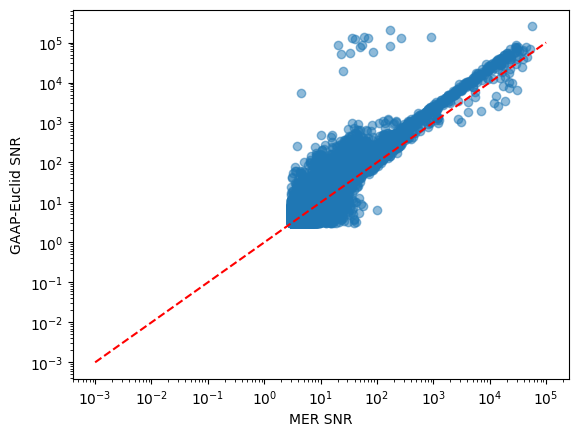

Percent of sources where GAAP-Euclid SNR > MER SNR: 0.788236307268343
Average SNR improvement factor (GAAP-Euclid / MER): 2.1078825419477174


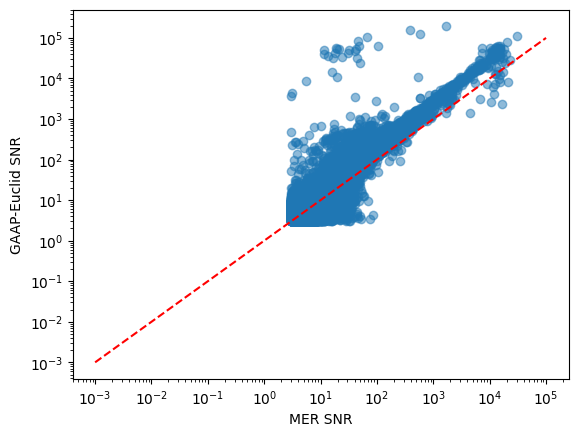

Percent of sources where GAAP-Euclid SNR > MER SNR: 0.8182826592958976
Average SNR improvement factor (GAAP-Euclid / MER): 2.5151194867412054


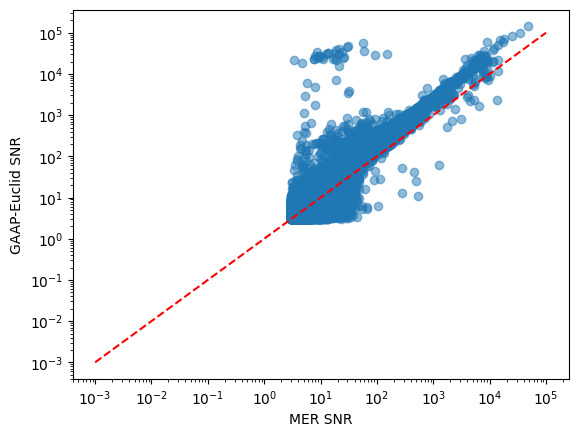

Percent of sources where GAAP-Euclid SNR > MER SNR: 0.8011879565781389
Average SNR improvement factor (GAAP-Euclid / MER): 3.2007271255376275


In [21]:
for filter in ['G', 'R', 'I']:
    snr_meer = cat[f'FLUX_{filter}_EXT_DECAM_4FWHM_APER'] / cat[f'FLUXERR_{filter}_EXT_DECAM_4FWHM_APER']
    snr_gaap_euclid = fluxes[f'flux_DES-{filter}']/fluxes[f'flux_DES-{filter}_sigma']
    cutoff_snr = 3
    mask = (snr_meer > cutoff_snr) & (snr_gaap_euclid > cutoff_snr) & (np.isfinite(snr_gaap_euclid)) & (np.isfinite(snr_meer))
    plt.scatter(snr_meer[mask],
                snr_gaap_euclid[mask],
                alpha=0.5)
    plt.plot([1e-3, 1e5], [1e-3, 1e5], 'r--')
    plt.xlabel('MER SNR')
    plt.ylabel('GAAP-Euclid SNR')
    plt.loglog()
    plt.show()
    print("Percent of sources where GAAP-Euclid SNR > MER SNR:", np.nansum(snr_gaap_euclid[mask] > snr_meer[mask])/ np.sum(~np.isnan(snr_gaap_euclid[mask])))
    print("Average SNR improvement factor (GAAP-Euclid / MER):", np.nanmean(snr_gaap_euclid[mask] / snr_meer[mask]))

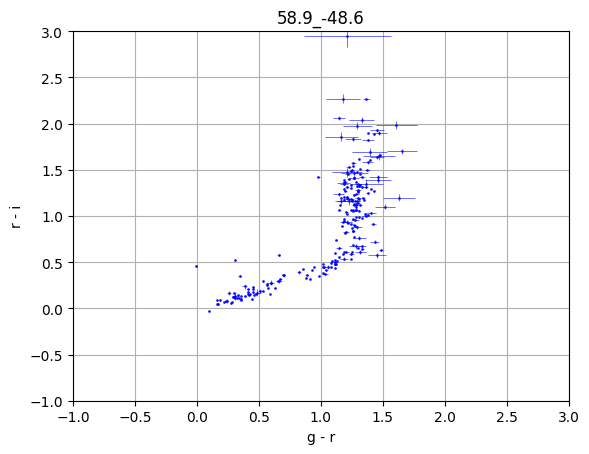

In [22]:
filter_1 = 'flux_g'   # e.g., master_table column name
filter_2 = 'flux_r'
filter_3 = 'flux_r'
filter_4 = 'flux_i'

plot_error = True

# Compute colors from master_table fluxes
x_color = -2.5 * np.log10(fluxes[filter_1] / fluxes[filter_2])
y_color = -2.5 * np.log10(fluxes[filter_3] / fluxes[filter_4])

# Compute errors from sigma dictionary
xerr = 2.5 / np.log(10) * np.sqrt(
    (fluxes[f'{filter_1}_sigma'] / fluxes[filter_1])**2 +
    (fluxes[f'{filter_2}_sigma'] / fluxes[filter_2])**2
)
yerr = 2.5 / np.log(10) * np.sqrt(
    (fluxes[f'{filter_3}_sigma'] / fluxes[filter_3])**2 +
    (fluxes[f'{filter_4}_sigma'] / fluxes[filter_4])**2
)

# Select star based on MER catalog
mask = cat['POINT_LIKE_PROB'] > 0.9
gaap_error = xerr**2 + yerr**2
plt.errorbar(
    x_color[mask], y_color[mask],
    xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
    fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8, label='GAAP'
)

plt.title(f'{field}')
plt.xlabel(f'{filter_1[5:]} - {filter_2[5:]}')
plt.ylabel(f'{filter_3[5:]} - {filter_4[5:]}')
plt.xlim(-1, 3)
plt.ylim(-1, 3)
plt.grid(True)
plt.show()

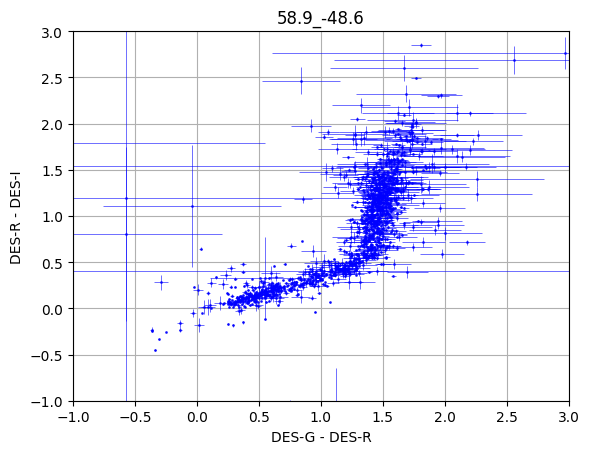

In [23]:
filter_1 = 'flux_DES-G'   # e.g., master_table column name
filter_2 = 'flux_DES-R'
filter_3 = 'flux_DES-R'
filter_4 = 'flux_DES-I'

plot_error = True

# Compute colors from master_table fluxes
x_color = -2.5 * np.log10(fluxes[filter_1] / fluxes[filter_2])
y_color = -2.5 * np.log10(fluxes[filter_3] / fluxes[filter_4])

# Compute errors from sigma dictionary
xerr = 2.5 / np.log(10) * np.sqrt(
    (fluxes[f'{filter_1}_sigma'] / fluxes[filter_1])**2 +
    (fluxes[f'{filter_2}_sigma'] / fluxes[filter_2])**2
)
yerr = 2.5 / np.log(10) * np.sqrt(
    (fluxes[f'{filter_3}_sigma'] / fluxes[filter_3])**2 +
    (fluxes[f'{filter_4}_sigma'] / fluxes[filter_4])**2
)

gaap_error = xerr**2 + yerr**2
# Select star based on MER catalog
mask = cat['POINT_LIKE_PROB'] > 0.9
plt.errorbar(
    x_color[mask], y_color[mask],
    xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
    fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8, label='GAAP'
)

plt.title(f'{field}')
plt.xlabel(f'{filter_1[5:]} - {filter_2[5:]}')
plt.ylabel(f'{filter_3[5:]} - {filter_4[5:]}')
plt.xlim(-1, 3)
plt.ylim(-1, 3)
plt.grid(True)
plt.show()

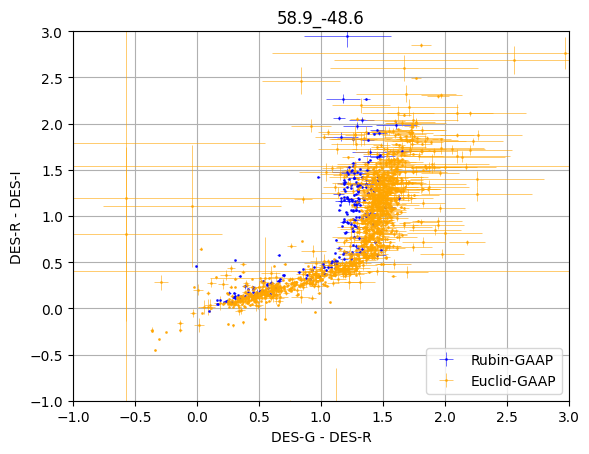

In [29]:
filter_1 = 'flux_g'   # e.g., master_table column name
filter_2 = 'flux_r'
filter_3 = 'flux_r'
filter_4 = 'flux_i'

plot_error = True

# Compute colors from master_table fluxes
x_color = -2.5 * np.log10(fluxes[filter_1] / fluxes[filter_2])
y_color = -2.5 * np.log10(fluxes[filter_3] / fluxes[filter_4])

# Compute errors from sigma dictionary
xerr = 2.5 / np.log(10) * np.sqrt(
    (fluxes[f'{filter_1}_sigma'] / fluxes[filter_1])**2 +
    (fluxes[f'{filter_2}_sigma'] / fluxes[filter_2])**2
)
yerr = 2.5 / np.log(10) * np.sqrt(
    (fluxes[f'{filter_3}_sigma'] / fluxes[filter_3])**2 +
    (fluxes[f'{filter_4}_sigma'] / fluxes[filter_4])**2
)

# Select star based on MER catalog
mask = cat['POINT_LIKE_PROB'] > 0.9
gaap_error = xerr**2 + yerr**2
plt.errorbar(
    x_color[mask], y_color[mask],
    xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
    fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8, label='Rubin-GAAP'
)

filter_1 = 'flux_DES-G'   # e.g., master_table column name
filter_2 = 'flux_DES-R'
filter_3 = 'flux_DES-R'
filter_4 = 'flux_DES-I'

plot_error = True

# Compute colors from master_table fluxes
x_color = -2.5 * np.log10(fluxes[filter_1] / fluxes[filter_2])
y_color = -2.5 * np.log10(fluxes[filter_3] / fluxes[filter_4])

# Compute errors from sigma dictionary
xerr = 2.5 / np.log(10) * np.sqrt(
    (fluxes[f'{filter_1}_sigma'] / fluxes[filter_1])**2 +
    (fluxes[f'{filter_2}_sigma'] / fluxes[filter_2])**2
)
yerr = 2.5 / np.log(10) * np.sqrt(
    (fluxes[f'{filter_3}_sigma'] / fluxes[filter_3])**2 +
    (fluxes[f'{filter_4}_sigma'] / fluxes[filter_4])**2
)

gaap_error = xerr**2 + yerr**2
# Select star based on MER catalog
mask = cat['POINT_LIKE_PROB'] > 0.9
plt.errorbar(
    x_color[mask], y_color[mask],
    xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
    fmt='o', c='orange', ms=1, elinewidth=0.5, alpha=0.8, label='Euclid-GAAP'
)

plt.title(f'{field}')
plt.xlabel(f'{filter_1[5:]} - {filter_2[5:]}')
plt.ylabel(f'{filter_3[5:]} - {filter_4[5:]}')
plt.xlim(-1, 3)
plt.ylim(-1, 3)
plt.grid(True)
plt.legend()
plt.show()

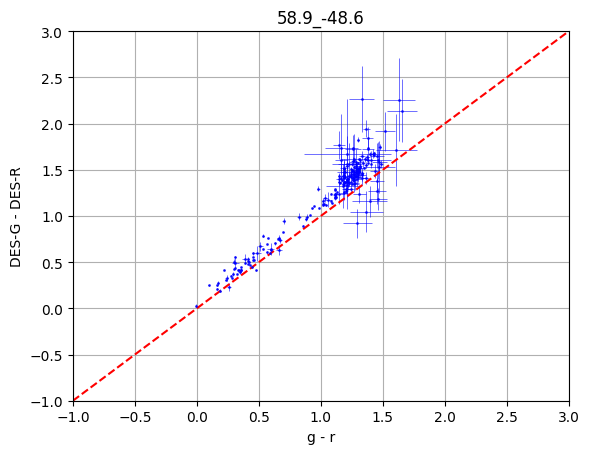

In [25]:
filter_1 = 'flux_g'   # e.g., master_table column name
filter_2 = 'flux_r'
filter_3 = 'flux_DES-G'   # e.g., master_table column name
filter_4 = 'flux_DES-R'

plot_error = True

# Compute colors from master_table fluxes
x_color = -2.5 * np.log10(fluxes[filter_1] / fluxes[filter_2])
y_color = -2.5 * np.log10(fluxes[filter_3] / fluxes[filter_4])

# Compute errors from sigma dictionary
xerr = 2.5 / np.log(10) * np.sqrt(
    (fluxes[f'{filter_1}_sigma'] / fluxes[filter_1])**2 +
    (fluxes[f'{filter_2}_sigma'] / fluxes[filter_2])**2
)
yerr = 2.5 / np.log(10) * np.sqrt(
    (fluxes[f'{filter_3}_sigma'] / fluxes[filter_3])**2 +
    (fluxes[f'{filter_4}_sigma'] / fluxes[filter_4])**2
)

# Select star based on MER catalog
mask = cat['POINT_LIKE_PROB'] > 0.9
gaap_error = xerr**2 + yerr**2
plt.errorbar(
    x_color[mask], y_color[mask],
    xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
    fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8, label='Rubin-GAAP'
)
plt.plot([-1, 3], [-1, 3], 'r--')
plt.title(f'{field}')
plt.xlabel(f'{filter_1[5:]} - {filter_2[5:]}')
plt.ylabel(f'{filter_3[5:]} - {filter_4[5:]}')
plt.xlim(-1, 3)
plt.ylim(-1, 3)
plt.grid(True)
plt.show()

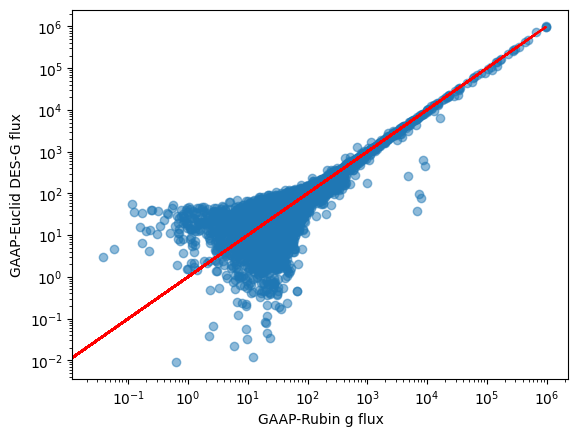

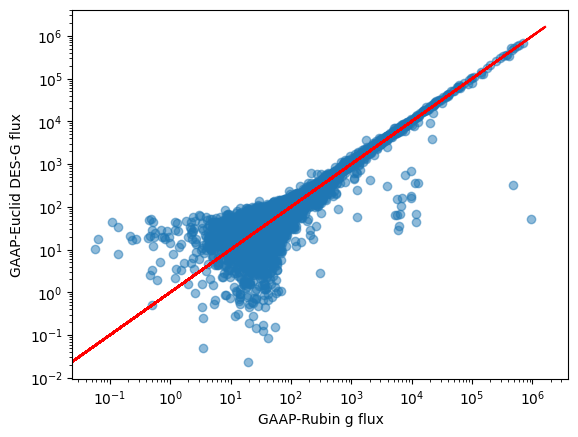

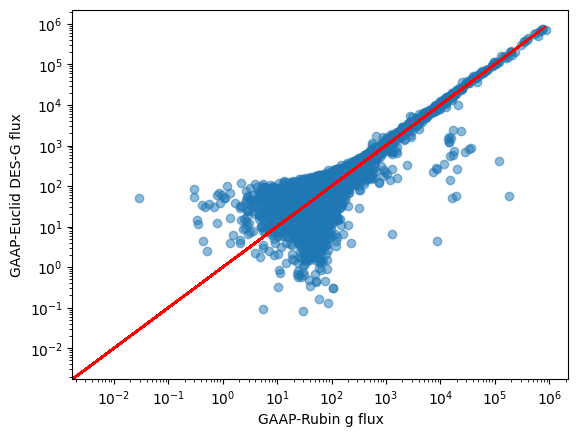

In [28]:
for filter in ['g', 'r', 'i']:
    plt.scatter(fluxes[f'flux_{filter}'], fluxes[f'flux_DES-{filter.upper()}'], alpha=0.5)
    plt.plot(fluxes[f'flux_{filter}'], fluxes[f'flux_{filter}'], 'r--')
    plt.xlabel('GAAP-Rubin g flux')
    plt.ylabel('GAAP-Euclid DES-G flux')
    plt.loglog()
    plt.show()

In [26]:
fluxes

,ra,dec,flux_u,flux_u_sigma,flux_g,flux_g_sigma,flux_r,flux_r_sigma,flux_i,flux_i_sigma,...,flux_DES-R_sigma,flux_DES-I,flux_DES-I_sigma,flux_NIR-Y,flux_NIR-Y_sigma,flux_NIR-J,flux_NIR-J_sigma,flux_NIR-H,flux_NIR-H_sigma,aperture_size
0,58.777718,-48.751563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.635922,31295.849609,32.369265,62782.714844,39.304921,84507.995605,30.882099,109878.320312,28.686598,0.7
1,59.350988,-48.751253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.635922,90.742415,32.369265,-1.716668,39.304921,117.711449,30.882099,193.089747,28.686598,0.7
2,58.700122,-48.751177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.635922,84.947246,32.369265,108.659458,39.304921,54.332131,30.882099,250.754476,28.686598,0.7
3,59.210771,-48.751501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.635922,111.985338,32.369265,200.206876,39.304921,153.502858,30.882099,176.890469,28.686598,0.7
4,59.311560,-48.751125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.635922,121.308267,32.369265,199.370110,39.304921,399.671268,30.882099,597.826052,28.686598,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111506,59.193674,-48.247057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.200002,15.274708,16.103654,145.139229,24.090058,140.042281,18.560620,141.356361,16.837963,1.1
111507,59.192450,-48.247195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.200002,24.886069,16.103654,179.072809,24.090058,169.820428,18.560620,202.759409,16.837963,1.1
111508,59.014606,-48.245891,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.200002,99.075091,16.103654,117.647243,24.090058,177.329016,18.560620,178.898704,16.837963,1.1
111509,59.014937,-48.245808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.635922,121.883380,32.369265,116.114581,39.304921,181.706572,30.882099,105.914795,28.686598,0.7
